## Convolutional NN to classify govuk content to level2 taxons

Based on:
https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

### Load requirements and data

TODO: edit requirement.txt to include only these packages and do not include tensorflow because this conflicts with tf on AWS when using on GPU.

In [45]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.utils import to_categorical, layer_utils, plot_model

from keras.layers import (Embedding, Input, Dense, Dropout, 
                          Activation, Conv1D, MaxPooling1D, Flatten, concatenate, Reshape)
from keras.models import Model, Sequential
from keras.optimizers import rmsprop
from keras.callbacks import TensorBoard, Callback, ModelCheckpoint
import keras.backend as K
from keras.losses import binary_crossentropy

from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score 
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.utils import class_weight

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import functools

import h5py

import time

### Environmental vars

In [46]:
DATADIR=os.getenv('DATADIR')
#DATADIR='/data' #this was put in for AWS run but doesn't work locally...

## Hyperparameters

Intuition for POS_RATIO is that it penalises the prediction of zero for everything, which is attractive to the model because the multilabel y matrix is super sparse. 

Increasing POS_RATIO should penalise predicting zeros more.

In [47]:
#MAX_NB_WORDS
MAX_SEQUENCE_LENGTH =1000
EMBEDDING_DIM = 100 # keras embedding layer output_dim = Dimension of the dense embedding
P_THRESHOLD = 0.5 #Threshold for probability of being assigned to class
POS_RATIO = 0.5 #ratio of positive to negative for each class in weighted binary cross entropy loss function
NUM_WORDS=20000 #keras tokenizer num_words: None or int. Maximum number of words to work with 
#(if set, tokenization will be restricted to the top num_words most common words in the dataset).

### Read in data
Content items tagged to level 2 taxons or lower in the topic taxonomy

In [48]:
labelled_level2 = pd.read_csv(os.path.join(DATADIR, 'labelled_level2.csv.gz'), dtype=object, compression='gzip')

In [49]:
labelled_level2.shape

(173560, 23)

In [50]:
labelled_level2['content_id'].nunique()

114048

#### clean up any World taxons leftover despite dropping relevant doctypes

In [51]:
#COLLAPSE World level2taxons
labelled_level2.loc[labelled_level2['level1taxon'] == 'World', 'level2taxon'] = 'world_level1'

#creating categorical variable for level2taxons from values
labelled_level2['level2taxon'] = labelled_level2['level2taxon'].astype('category')

In [52]:
#count the number of content items per taxon into new column
labelled_level2['num_content_per_taxon'] = labelled_level2.groupby(["level2taxon"])['level2taxon'].transform("count")

In [53]:
labelled_level2['num_content_per_taxon'].describe()

count    173560.000000
mean       4574.207145
std        3682.635048
min           1.000000
25%        1500.000000
50%        3780.000000
75%        6156.000000
max       11717.000000
Name: num_content_per_taxon, dtype: float64

In [54]:
#number of rows in biggest level2 taxon -this is the target size for all other level2 taxons in resampling
max_content_freq = max(labelled_level2['num_content_per_taxon'])
max_content_freq

11717

### drop news

In [55]:
labelled_level2.shape

(173560, 24)

In [56]:
labelled_level2[(labelled_level2['document_type'] == 'world_news_story')].shape

(3927, 24)

In [57]:
labelled_level2[(labelled_level2['document_type'] == 'news_story')].shape

(33214, 24)

In [58]:
nonews = labelled_level2[(labelled_level2['document_type'] != 'news_story') &
                         (labelled_level2['document_type'] != 'world_news_story')]

In [59]:
nonews.shape

(136419, 24)

### Create dictionary mapping taxon codes to string labels

In [60]:
#Get the category numeric values (codes) and avoid zero-indexing
labels = nonews['level2taxon'].cat.codes + 1

#create dictionary of taxon category code to string label for use in model evaluation
labels_index = dict(zip((labels), nonews['level2taxon']))

In [61]:
#labels_index

In [62]:
print(len(labels_index))

210


### Create target/Y 

Note: when using the categorical_crossentropy loss, your targets should be in categorical format (e.g. if you have 10 classes, the target for each sample should be a 10-dimensional vector that is all-zeros expect for a 1 at the index corresponding to the class of the sample).

In multilabel learning, the joint set of binary classification tasks is expressed with label binary indicator array: each sample is one row of a 2d array of shape (n_samples, n_classes) with binary values:  
the one, i.e. the non zero elements, corresponds to the subset of labels.  
An array such as np.array([[1, 0, 0], [0, 1, 1], [0, 0, 0]]) represents label 0 in the first sample, labels 1 and 2 in the second sample, and no labels in the third sample.  
Producing multilabel data as a list of sets of labels may be more intuitive.

####  First reshape wide to get columns for each level2taxon and row number = number unique urls

In [63]:
#get a smaller copy of data for pivoting ease (think you can work from full data actually and other cols get droopedauto)

level2_reduced = nonews[['content_id', 
                         'level2taxon', 
                         'combined_text', 
                         'title', 
                         'description',
                         'document_type', 
                            'first_published_at', 
                            'publishing_app', 
                            'primary_publishing_organisation']].copy()

#how many level2taxons are there?
print('Number of unique level2taxons: {}'.format(level2_reduced.level2taxon.nunique()))

#count the number of taxons per content item into new column
level2_reduced['num_taxon_per_content'] = level2_reduced.groupby(["content_id"])['content_id'].transform("count")

#Add 1 because of zero-indexing to get 1-number of level2taxons as numerical targets
level2_reduced['level2taxon_code'] = level2_reduced.level2taxon.astype('category').cat.codes + 1

Number of unique level2taxons: 210


In [64]:
#how many level2taxons are there?
print('Number of unique level2taxons: {}'.format(labelled_level2.level2taxon.nunique()))

#count the number of taxons per content item into new column
labelled_level2['num_taxon_per_content'] = labelled_level2.groupby(["content_id"])['content_id'].transform("count")

#Add 1 because of zero-indexing to get 1-number of level2taxons as numerical targets
labelled_level2['level2taxon_code'] = labelled_level2.level2taxon.astype('category').cat.codes + 1

Number of unique level2taxons: 210


In [65]:
#reshape to wide per taxon and keep the combined text so indexing is consistent when splitting X from Y

multilabel = (level2_reduced.pivot_table(index=['content_id', 
                                                'combined_text', 
                                                'title', 
                                                'description' 
                                                ] , columns='level2taxon_code', values='num_taxon_per_content'))
print('level2reduced shape: {}'.format(level2_reduced.shape))
print('pivot table shape (no duplicates): {} '.format(multilabel.shape))


level2reduced shape: (136419, 11)
pivot table shape (no duplicates): (92338, 210) 


In [66]:
multilabel.columns

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            201, 202, 203, 204, 205, 206, 207, 208, 209, 210],
           dtype='int64', name='level2taxon_code', length=210)

In [67]:
multilabel.head()

,,,level2taxon_code,1,2,3,4,5,6,7,8,9,10,...,201,202,203,204,205,206,207,208,209,210
content_id,combined_text,title,description,,,,,,,,,,,,,,,,,,,,,
00029fa4-9b60-4285-898c-85ae8a6367f5,emma jones - small business crown representative as small business crown representative emma is keen to help uk smes win government business. emma was appointed as small business crown representative in july 2016. she was selected for the role because of her wealth of experience in working with smes. she is the founder of small business support group enterprise nation and the co-founder of startup britain. emma’s work in her role as small business crown representative includes: working with government and the small business panel to identify the remaining barriers to smes doing business with the public sector supporting the launch and delivery of the campaign to help show that government is “open for business” for smes and helping them bid for and win more contracts increasing awareness among smaller businesses of opportunities to deliver on behalf of larger private sector firms who have secured government contracts working with government to identify new opportunities to get best value from smes getting support emma is keen to hear what small business have to say and wants to engage with as many smes as possible. so if you’re thinking about becoming a government supplier take a look at the events and opportunities below for how to get involved and gain support. events the leeds cross government sme roadshow - 24 november 2017 - is a great opportunity for smes to hear directly about the opportunities to sell to the public sector. more information about the event and how to register can be found here. webinars register for free for emma’s half-hour webinars offering advice on how to become a government supplier. a list of webinars coming up is featured below. blogs read emma’s blogs to gain useful insight updates and tips for smes and government buyers. these smes did it and so can you! prompt payment makes for good business 2017 a big year for small businesses calling central government buyers: emma can help you meet your target small business saturday dec 2016: top tips for selling to government selling to the public sector guide in partner with the crown commercial service emma has developed a guide for small businesses with tips on selling to government. read here . government is open for business ‘open for business’ is the government’s campaign to reach more smes as potential suppliers: to help and support them to become suppliers and to listen to how government can improve the process. for more information visit www.gov.uk/openforbusiness register with contracts finder to keep updated on new and upcoming contracts worth over £10 000. for inspiration on how other small business have grown and benefitted from being a supplier government read our case studies . if you would like to help in getting the message out that government is open for business then visit the resources page for ways in which you can support.,emma jones - small business crown representative,as small business crown representative emma is keen to help uk smes win government business.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00037b70-5b08-44c2-bf0a-fa8eb636a60b,land remediation: bringing brownfield sites back to use brochure showing uk expertise in land remediation outlining technologies systems and ideas used in the regeneration of industrial land. the uk was the first industrialised country in the world. the legacy of the industrial revolution is over 400 000 hectares of contaminated land. uk expertise in land remediation has been borne out of necessity. the department for international trade’s ( dit ) brochure provides an overview of the expertise gained from over 5 decades of experience in land remediation. the brochure includes information on: sector specialists urban regeneration spill response monitoring and validation corpor

In [68]:
multilabel.columns.astype('str')

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '201', '202', '203', '204', '205', '206', '207', '208', '209', '210'],
      dtype='object', name='level2taxon_code', length=210)

In [69]:
#THIS IS WHY INDEXING IS NOT ZERO-BASED
#convert the number_of_taxons_per_content values to 1, meaning there was an entry for this taxon and this content_id, 0 otherwise
binary_multilabel = multilabel.notnull().astype('int')

## Data Pre-Processing

In [70]:
total_size = binary_multilabel.shape[0]
total_size

92338

In [71]:
nb_test_samples = int(0.1 * total_size) #test split
print('nb_test samples:', nb_test_samples)

nb_dev_samples = int(0.2 * total_size) #dev split
print('nb_dev samples:', nb_dev_samples)

nb_training_samples = int(0.8 * total_size) #train split
print('nb_training samples:', nb_training_samples)

nb_test samples: 9233
nb_dev samples: 18467
nb_training samples: 73870


### Shuffle

In [72]:
for i in range(0,10):
    print(binary_multilabel.index[i][0])

00029fa4-9b60-4285-898c-85ae8a6367f5
00037b70-5b08-44c2-bf0a-fa8eb636a60b
00037ee5-7b5e-452d-a233-af2c134f5bce
0004c63d-ae16-432a-bb35-c0f949b1e27c
0005ac76-50fe-42f1-8168-8b6fc046e40f
0006811c-ad80-4cd0-a732-04cc983ec8c2
0008f82f-9713-4074-8793-0d266d53930c
000aa34d-c3c0-4176-ad8a-50e801056df1
000b6a38-c69a-4ac9-918b-717a79cbdad2
000b8c7e-4671-4586-9eff-97c0c374126b


00029fa4-9b60-4285-898c-85ae8a6367f5
00037b70-5b08-44c2-bf0a-fa8eb636a60b
00037ee5-7b5e-452d-a233-af2c134f5bce
0004c63d-ae16-432a-bb35-c0f949b1e27c
0005ac76-50fe-42f1-8168-8b6fc046e40f
0006811c-ad80-4cd0-a732-04cc983ec8c2
0008f82f-9713-4074-8793-0d266d53930c
000aa34d-c3c0-4176-ad8a-50e801056df1
000b6a38-c69a-4ac9-918b-717a79cbdad2
000b8c7e-4671-4586-9eff-97c0c374126b

In [73]:
from sklearn.utils import shuffle

In [74]:
binary_multilabel = shuffle(binary_multilabel,random_state=0)

In [75]:
for i in range(0,10):
    print(binary_multilabel.index[i][0])

1372d620-2c7b-4c06-a6e7-c60cacdb4d58
d8132578-37d9-4f47-a438-86530b0ff259
5c8fa231-7631-11e4-a3cb-005056011aef
5f2bc84b-6fb0-48f7-9fab-41387b1d72fe
5df423c9-7631-11e4-a3cb-005056011aef
a1c32b79-e6b9-40b1-8095-150727418ea1
5bfd33c7-63bb-42d0-a6c7-9c2c03739165
5dc916ad-7631-11e4-a3cb-005056011aef
dabfc6b3-d88c-458f-a9fb-f286b987509b
5c71ba56-7631-11e4-a3cb-005056011aef


df76ffdf-70d6-4a38-9d60-a1765c18914e
dca1f897-c8bd-4e35-a839-5953ee94d54e
3bec5cd0-76bd-48b1-924a-567bd3361ec0
5eb7cd3c-7631-11e4-a3cb-005056011aef
a67385c3-8562-4dc1-96ba-d96ff215943b
5e35118a-7631-11e4-a3cb-005056011aef
5feb658b-7631-11e4-a3cb-005056011aef
144a86f9-6902-444c-87bc-b389a6f3b275
5e139390-7631-11e4-a3cb-005056011aef
e5741923-bc21-46bd-8832-886706f59e81

### Upsample minority classes to address imbalance leading to ~2, 465, 570 rows of data!

Access taxon columns with indexing. 

In [76]:
print("[ENCODING] Taxon min indx:",binary_multilabel.columns[0],"Taxon max indx:",
      binary_multilabel.columns[len(binary_multilabel.columns)-1])

[ENCODING] Taxon min indx: 1 Taxon max indx: 210


In [77]:
binary_multilabel[1].shape

(92338,)

In [78]:
type(binary_multilabel.columns[0])

numpy.int64

In [79]:
### Array with indices to upsample

In [80]:
index = [binary_multilabel.index[i][0] for i in range(0,nb_training_samples)]
print(len(index))

73870


In [81]:
binary_multilabel[binary_multilabel[1]==1].loc[index].head()

,,,level2taxon_code,1,2,3,4,5,6,7,8,9,10,...,201,202,203,204,205,206,207,208,209,210
content_id,combined_text,title,description,,,,,,,,,,,,,,,,,,,,,
714b7c4c-269a-40fd-b3d8-41eda3d5517a,merger of local justice areas in greater manchester seeks views on merging 8 local justice areas (ljas) into a single lja to be known as the greater manchester lja. there are 3 key reasons for considering a merger of the current 8 ljas: to improve the effectiveness of the delivery of justice by improving flexibility in dealing with cases to make better use of reduced resources to increase the opportunities for magistrates to retain experience and thus competence the judicial business group (jbg) must address the question of magistrates’ sittings against the background of falling court sittings in criminal jurisdiction. the jbg must also consider the resources available to hmcts and criminal justice agencies to ensure that justice can be delivered as effectively as possible with reduced resources. staffing within hmcts and other organisations is determined by the workload and has therefore reduced over recent years.,merger of local justice areas in greater manchester,seeks views on merging 8 local justice areas (ljas) into a single lja to be known as the greater manchester lja.,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5f617c08-7631-11e4-a3cb-005056011aef,gwent magistrates' courts: proposals for the future this is a consultation on a proposal to close abergavenny magistrates' court and caerphilly magistrates' court. both abergavenny magistrates’ court and caerphilly magistrates’ court are in need of restoration and hm courts and tribunals service would incur considerable costs in making necessary repairs. it is proposed that both courts close and the workload be absorbed by the other 2 magistrates’ courts in gwent - newport and cwmbran. this proposal aims to ensure our court estate is used more efficiently and the closure of the courts would offer hm courts and tribunals service savings of around £80 000 a year. this consultation seeks the views of local users judiciary magistracy staff criminal justice agency practitioners and elected representatives to better understand the impact that this proposal would have on the gwent community.,gwent magistrates' courts: proposals for the future,this is a consultation on a proposal to close abergavenny magistrates' court and caerphilly magistrates' court.,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5f641586-7631-11e4-a3cb-005056011aef,two appointments for the judicial appointments commission judge phillip sycamore and judge usha karu appointed as commissioners of the judicial appointments commission. the lord chancellor today announced the appointment by her majesty the queen of his honour judge phillip sycamore as a senior judicial commissioner and her honour judge usha karu as the circuit judge member of the judicial appointments commission (jac). the appointments of his and her honour are for a 3 year period commencing 9 june 2014 with the possibility subject to the provisions of the constitutional reform act 2005 of renewal for a total period not exceeding 10 years. as serving salaried judges these posts are unpaid. the jac is an independent commission that selects candidates for judicial office in courts and tribunals in england and wales and for some tribunals whose jurisdiction extends to scotland or northern ireland. the jac selects candidates for judicial office on merit through fair and open competition from the widest range of eligible candidates. the jac comprises a chairman and 14 commissioners. the jac has a senior management team comprising the chief executive and a director and is supported by 67 staff. biographies his honour judge phillip sycamore judge sycamore was appointed as a circuit judge in 2001 and is currently the chamber president of the first tier tribunal (health education and social care chamber) a judge of the upper tribunal (administrative appeals chamber) and a deputy h

In [82]:
# Why are we deleting this?
del binary_multilabel.columns.name

In [83]:
#TAKES FOREVER TO RUN!
from sklearn.utils import resample

In [84]:
upsampled_training = pd.DataFrame()
upper = len(binary_multilabel.columns)+1

for taxon in range(1, upper):
    num_samples = binary_multilabel[binary_multilabel[taxon]==1].shape[0] 
    if num_samples<500:
        print("Taxon code:",taxon,"Taxon name:",labels_index[taxon])
        print("SMALL SUPPORT:",num_samples)
        df_minority = binary_multilabel[binary_multilabel[taxon]==1].loc[index]
        if not df_minority.empty:
        # Upsample minority class
            print(df_minority.shape)
            df_minority_upsampled = resample(df_minority, 
                                                 replace=True,     # sample with replacement
                                                 n_samples=(500),    # to match majority class, switch to max_content_freq if works
                                                 random_state=123) # reproducible results
            
            print("FIRST 5 IDs:",[df_minority_upsampled.index[i][0] for i in range(0,5)])

            # Combine majority class with upsampled minority class
            upsampled_training = pd.concat([upsampled_training, df_minority_upsampled])

            # Display new shape
            print("UPSAMPLING:",upsampled_training.shape)

upsampled_training = shuffle(upsampled_training,random_state=0)

Taxon code: 1 Taxon name: Administrative justice reform
SMALL SUPPORT: 11
(10, 210)
FIRST 5 IDs: ['5f641586-7631-11e4-a3cb-005056011aef', '5f641586-7631-11e4-a3cb-005056011aef', 'fd0b66df-bab6-4e8a-bd7b-bb12a8ca63ca', '5f617c08-7631-11e4-a3cb-005056011aef', '8ea3bdc9-05ff-4416-8874-248a13bc7610']
UPSAMPLING: (500, 210)
Taxon code: 2 Taxon name: Adoption, fostering and surrogacy
SMALL SUPPORT: 69
(63, 210)
FIRST 5 IDs: ['0bf1fd2f-1798-421c-b9d3-36ced36d075b', '12eb9924-2e33-4222-b823-3e0e6ce2924d', '0bf1fd2f-1798-421c-b9d3-36ced36d075b', '5f4b08f5-7631-11e4-a3cb-005056011aef', '668f7b53-8546-49be-80de-7685c5350653']
UPSAMPLING: (1000, 210)
Taxon code: 3 Taxon name: Afghanistan
SMALL SUPPORT: 81
(64, 210)
FIRST 5 IDs: ['5e9c7226-7631-11e4-a3cb-005056011aef', '5ebdf67c-7631-11e4-a3cb-005056011aef', '5e9c7226-7631-11e4-a3cb-005056011aef', '5e94adff-7631-11e4-a3cb-005056011aef', '5e29a0b2-7631-11e4-a3cb-005056011aef']
UPSAMPLING: (1500, 210)
Taxon code: 4 Taxon name: Armed Forces Covenant
S

(41, 210)
FIRST 5 IDs: ['77a514da-8fa5-405b-b0aa-cd16020d6edd', '5e966702-7631-11e4-a3cb-005056011aef', '5e5d6180-7631-11e4-a3cb-005056011aef', 'f917915c-c52a-484c-b343-726c49327e3f', '5e135611-7631-11e4-a3cb-005056011aef']
UPSAMPLING: (13500, 210)
Taxon code: 33 Taxon name: Civil justice reform
SMALL SUPPORT: 3
(3, 210)
FIRST 5 IDs: ['c2734a07-31c8-4306-bb1c-d8038dba326e', 'ce9ceea5-e8b5-497d-ae73-e8290dcb5a5d', 'c2734a07-31c8-4306-bb1c-d8038dba326e', 'c2734a07-31c8-4306-bb1c-d8038dba326e', 'c4445136-1bae-46e6-b8a1-55640dc14f80']
UPSAMPLING: (14000, 210)
Taxon code: 34 Taxon name: Civil service reform
SMALL SUPPORT: 358
(277, 210)
FIRST 5 IDs: ['ed6ef793-b9e8-47f6-b757-6714f9559f2f', 'ad5d0235-24e2-49c6-93ed-0952520f369d', 'b10785ef-5454-4648-9e5e-861fec0ccf52', '5fd93319-7631-11e4-a3cb-005056011aef', '74f36b27-bca1-45a6-a894-f602c1281de1']
UPSAMPLING: (14500, 210)
Taxon code: 36 Taxon name: Commercial fishing and fisheries
SMALL SUPPORT: 263
(215, 210)
FIRST 5 IDs: ['5f1f85f6-7631-11

(8, 210)
FIRST 5 IDs: ['5c7166fe-7631-11e4-a3cb-005056011aef', '5c838a0c-7631-11e4-a3cb-005056011aef', '5c7166fe-7631-11e4-a3cb-005056011aef', '5c838905-7631-11e4-a3cb-005056011aef', '5f1ad877-7631-11e4-a3cb-005056011aef']
UPSAMPLING: (26500, 210)
Taxon code: 68 Taxon name: European funds
SMALL SUPPORT: 82
(61, 210)
FIRST 5 IDs: ['ed031242-6195-4d23-9588-9fb1d341db48', 'b99b2e66-9f5b-4325-b1ac-e46b13e8cdac', '5c98c569-7631-11e4-a3cb-005056011aef', 'fb09c7a2-9e74-4ff8-94f9-79ce8598170a', '6028fa6a-7631-11e4-a3cb-005056011aef']
UPSAMPLING: (27000, 210)
Taxon code: 69 Taxon name: European single market
SMALL SUPPORT: 142
(105, 210)
FIRST 5 IDs: ['9f3d84a1-7243-46ae-8dcf-36abdf3bacb1', '5d60dfcf-7631-11e4-a3cb-005056011aef', 'ec8125be-2409-46a3-98cc-2664a81131e5', '9fea336a-e759-4301-8fa1-fa2e4ab499c6', '5c993e48-7631-11e4-a3cb-005056011aef']
UPSAMPLING: (27500, 210)
Taxon code: 70 Taxon name: Expenses and employee benefits
SMALL SUPPORT: 8
(6, 210)
FIRST 5 IDs: ['f6046a19-8312-412c-aeaa-9

UPSAMPLING: (39000, 210)
Taxon code: 104 Taxon name: Land registration
SMALL SUPPORT: 140
(112, 210)
FIRST 5 IDs: ['5f6499f6-7631-11e4-a3cb-005056011aef', '5f50d72a-7631-11e4-a3cb-005056011aef', '305e0f09-a541-41b0-b317-5f8ba7148647', '5f66e6be-7631-11e4-a3cb-005056011aef', '5f4fe1c5-7631-11e4-a3cb-005056011aef']
UPSAMPLING: (39500, 210)
Taxon code: 105 Taxon name: Lasting power of attorney, being in care and your financial affairs
SMALL SUPPORT: 21
(15, 210)
FIRST 5 IDs: ['ef1207f4-4cec-4448-988d-997d795793af', 'faa1492b-e7ad-42de-80e3-c5a2c9043972', 'ef1207f4-4cec-4448-988d-997d795793af', '136bfef2-354c-474b-bf97-a6d39ec4248b', 'f508898d-1ba0-46f7-b150-828166886d97']
UPSAMPLING: (40000, 210)
Taxon code: 106 Taxon name: Law and practice
SMALL SUPPORT: 55
(48, 210)
FIRST 5 IDs: ['875fbcdb-5d8e-4310-a281-2597ec8b9c40', 'd6ef1190-e58c-42b1-98f6-6629b16d25d6', '5fee6f5a-7631-11e4-a3cb-005056011aef', '5f65f4e4-7631-11e4-a3cb-005056011aef', '0b1014ce-b0ad-46c1-9753-ec9a8f21cb87']
UPSAMPLING

(28, 210)
FIRST 5 IDs: ['dfa28d6c-c181-4b96-af95-30f24d66ff28', '5d81b47b-7631-11e4-a3cb-005056011aef', '5d81b47b-7631-11e4-a3cb-005056011aef', '6bcb87c7-0d26-4fb0-8079-c2dfa09220f3', '52d01c9e-fa5c-4e26-b309-bae92dc1c4bc']
UPSAMPLING: (52000, 210)
Taxon code: 137 Taxon name: Payroll
SMALL SUPPORT: 40
(33, 210)
FIRST 5 IDs: ['eed1c39e-523c-4e54-8025-eed301b61e62', '5dd79407-0213-4675-9754-d6cfd1118f87', 'a4fa57a8-8a70-4b66-a7ba-22f5103b6378', 'a0a16869-906d-4b7e-8e43-bee9a60cc853', 'b8b5b409-a2cc-4b6c-972d-eb7072c21626']
UPSAMPLING: (52500, 210)
Taxon code: 140 Taxon name: Permanent stay in the UK
SMALL SUPPORT: 33
(26, 210)
FIRST 5 IDs: ['5ec23dca-7631-11e4-a3cb-005056011aef', '5ee540bf-7631-11e4-a3cb-005056011aef', '5ee540bf-7631-11e4-a3cb-005056011aef', '5ec20675-7631-11e4-a3cb-005056011aef', 'f4c6ac13-1769-4e0a-aba5-46eedaab2bcf']
UPSAMPLING: (53000, 210)
Taxon code: 142 Taxon name: Policing
SMALL SUPPORT: 487
(391, 210)
FIRST 5 IDs: ['5ff07d1d-7631-11e4-a3cb-005056011aef', '5f5e74

UPSAMPLING: (64500, 210)
Taxon code: 177 Taxon name: Tax evasion and avoidance
SMALL SUPPORT: 122
(86, 210)
FIRST 5 IDs: ['5d63d132-7631-11e4-a3cb-005056011aef', '5e5b0b50-7631-11e4-a3cb-005056011aef', 'af5df0b0-e289-4b43-971e-ad210505a148', '5e340b3a-7631-11e4-a3cb-005056011aef', '5ebdf67c-7631-11e4-a3cb-005056011aef']
UPSAMPLING: (65000, 210)
Taxon code: 179 Taxon name: The Commonwealth
SMALL SUPPORT: 50
(42, 210)
FIRST 5 IDs: ['5ebf06c2-7631-11e4-a3cb-005056011aef', 'c34a1171-6177-490b-933c-b78f05336424', 'f2c7b7f3-f712-4b27-ae97-e60e9cdf626b', '5dc62156-7631-11e4-a3cb-005056011aef', '487eefe2-17d8-4b37-a117-93ce05e2469c']
UPSAMPLING: (65500, 210)
Taxon code: 180 Taxon name: Tourism
SMALL SUPPORT: 118
(94, 210)
FIRST 5 IDs: ['5d3c07de-7631-11e4-a3cb-005056011aef', 'cb809fec-0fb5-4146-bf43-9d5272765099', '0cd922e9-1cea-4adf-a7a5-cd3c545f45ae', '5d60e381-7631-11e4-a3cb-005056011aef', '5d339a90-7631-11e4-a3cb-005056011aef']
UPSAMPLING: (66000, 210)
Taxon code: 182 Taxon name: Transport

### Doublecheck dataframe contents before merging.

In [85]:
binary_multilabel.shape

(92338, 210)

In [86]:
binary_multilabel.index[91770][0] # final sample before merging.

'7e4943f3-3acd-4929-bdcd-d6a254d4dec1'

In [87]:
binary_multilabel = pd.concat([binary_multilabel, upsampled_training])

In [88]:
binary_multilabel.index[total_size][0] # first sample of duplicated training data

'5db8ea74-7631-11e4-a3cb-005056011aef'

Do not remove index because the text data lives there.
**TODO** Consider reworking how datasets are set up at some point

In [89]:
binary_multilabel.to_csv(os.path.join(DATADIR, 'balanced_level2_training_set_sampled.csv.gz'), compression='gzip')

### LOAD OVERSAMPLED DATASET

In [90]:
balanced_df = pd.read_csv(os.path.join(DATADIR, 'balanced_level2_training_set_sampled.csv.gz'), dtype=object, compression='gzip')

In [91]:
balanced_df.shape

(169338, 214)

In [92]:
#will convert columns to an array of shape
print('Shape of Y multilabel array before train/val/test split:{}'.format(balanced_df[list(balanced_df.columns)].values.shape))

Shape of Y multilabel array before train/val/test split:(169338, 214)


In [93]:
#dont' overwirte blanced_df as it take sages to read in
balanced_df_taxons = balanced_df.iloc[:,4:215]

In [94]:
balanced_df_taxons.columns = balanced_df_taxons.columns.astype(int)

In [95]:
balanced_df_taxons = balanced_df_taxons.astype(int)

In [96]:
#convert columns to an array. Each row represents a content item, each column an individual taxon
binary_multilabel = balanced_df_taxons[list(balanced_df_taxons.columns)].values
print('Example row of multilabel array {}'.format(binary_multilabel[2]))

Example row of multilabel array [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [97]:
balanced_df.head()

,content_id,combined_text,title,description,1,2,3,4,5,6,...,201,202,203,204,205,206,207,208,209,210
0,1372d620-2c7b-4c06-a6e7-c60cacdb4d58,drug strategy 2017 the drug strategy 2017 sets...,drug strategy 2017,the drug strategy 2017 sets out how the govern...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,d8132578-37d9-4f47-a438-86530b0ff259,bees and ants to flourish while the cuckoo flo...,bees and ants to flourish while the cuckoo flo...,climate change research reveals species most a...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5c8fa231-7631-11e4-a3cb-005056011aef,defence training estate warcop: public access ...,defence training estate warcop: public access ...,scheduled public access to the defence trainin...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5f2bc84b-6fb0-48f7-9fab-41387b1d72fe,chevras machzikei mesifta: 2016 inquiry report...,chevras machzikei mesifta: 2016 inquiry report,chevras machzikei mesifta: charity commission ...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5df423c9-7631-11e4-a3cb-005056011aef,rail franchising a statement about the refranc...,rail franchising,a statement about the refranchising programme ...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Format metadata/X

In [98]:
#extract content_id index to df
meta1 = pd.DataFrame(balanced_df['content_id'])

In [99]:
print(meta1.shape)
meta1.head()

(169338, 1)


,content_id
0,1372d620-2c7b-4c06-a6e7-c60cacdb4d58
1,d8132578-37d9-4f47-a438-86530b0ff259
2,5c8fa231-7631-11e4-a3cb-005056011aef
3,5f2bc84b-6fb0-48f7-9fab-41387b1d72fe
4,5df423c9-7631-11e4-a3cb-005056011aef


In [100]:
metas = ['document_type','first_published_at','publishing_app','primary_publishing_organisation']

In [101]:
def build_index(x):
    index_dict = {}
    index_dict['index'] = 0
    for i,elem in enumerate(x):
        index_dict[elem] = i+1
    return index_dict

In [102]:
import time

In [103]:
#IF THIS FUNCTION TURNS OUT FASTER KEEP
#apply meta data to content
print("STARTED:",time.strftime("%H:%M:%S"))
for meta in metas:
    print("WORKON:",meta)
    meta1[meta] = meta1['content_id'].map(dict(zip(labelled_level2['content_id'], labelled_level2[meta])))
print("FINISHED:",time.strftime("%H:%M:%S"))

STARTED: 21:38:41
WORKON: document_type
WORKON: first_published_at
WORKON: publishing_app
WORKON: primary_publishing_organisation
FINISHED: 21:38:41


In [104]:
meta1 = meta1.replace(np.nan, '', regex=True) #conver nans to empty strings for labelencoder types
meta1.head()

,content_id,document_type,first_published_at,publishing_app,primary_publishing_organisation
0,1372d620-2c7b-4c06-a6e7-c60cacdb4d58,policy_paper,2017-07-13T23:00:26.000+00:00,whitehall,{'title': 'Home Office'}
1,d8132578-37d9-4f47-a438-86530b0ff259,press_release,2015-07-22T08:10:53.000+00:00,whitehall,{'title': 'Natural England'}
2,5c8fa231-7631-11e4-a3cb-005056011aef,guidance,2012-07-04T00:00:00.000+00:00,whitehall,{'title': 'Ministry of Defence'}
3,5f2bc84b-6fb0-48f7-9fab-41387b1d72fe,decision,2016-07-13T10:03:31.000+00:00,whitehall,{'title': 'The Charity Commission'}
4,5df423c9-7631-11e4-a3cb-005056011aef,oral_statement,2013-03-26T00:00:00.000+00:00,whitehall,{'title': 'Department for Transport'}


In [105]:
def to_cat_to_hot(column):
    doctype_encoder = LabelEncoder()
    new_col = column+"_cat"
    meta1[new_col] = doctype_encoder.fit_transform(meta1[column])
    tf.cast(meta1[new_col], tf.float32)
    return to_categorical(meta1[new_col])

dict_of_encodings = {}
for meta in metas:
    if meta != "first_published_at":
        print(meta)
        dict_of_encodings[meta] = to_cat_to_hot(meta)   

document_type
publishing_app
primary_publishing_organisation


In [106]:
dict_of_encodings

{'document_type': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 'primary_publishing_organisation': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 'publishing_app': array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.]])}

In [107]:
type(meta1['first_published_at'][0])

str

In [108]:
meta1['first_published_at'] = pd.to_datetime(meta1['first_published_at'])
print(meta1['first_published_at'].shape)

(169338,)


In [109]:
first_published = np.array(meta1['first_published_at']).reshape(meta1['first_published_at'].shape[0], 1)

In [110]:
print(first_published.dtype,first_published.shape,type(first_published))

datetime64[ns] (169338, 1) <class 'numpy.ndarray'>


In [111]:
first_published[0]

array(['2017-07-13T23:00:26.000000000'], dtype='datetime64[ns]')

In [112]:
meta1['first_published_at'].loc[meta1['first_published_at'] < '1970']

10461   1955-01-01 00:00:00
17755   1969-07-24 00:00:00
50923   1961-02-27 00:00:00
51324   1965-04-05 23:00:00
86399   1963-02-28 00:00:00
Name: first_published_at, dtype: datetime64[ns]

In [113]:
first_published[first_published < np.datetime64('1970')]

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: In the future, 'NAT < x' and 'x < NAT' will always be False.
  if __name__ == '__main__':


array(['1955-01-01T00:00:00.000000000', '1969-07-24T00:00:00.000000000',
       'NaT', '1961-02-27T00:00:00.000000000',
       '1965-04-05T23:00:00.000000000', '1963-02-28T00:00:00.000000000'], dtype='datetime64[ns]')

In [114]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()

first_published_scaled =scaler.fit_transform(first_published)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype datetime64[ns] was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [115]:
from scipy import stats

print(stats.describe(first_published_scaled))


DescribeResult(nobs=169338, minmax=(array([ 0.]), array([ 1.])), mean=array([ 0.98993999]), variance=array([  7.61789979e-05]), skewness=array([-11.94071949]), kurtosis=array([ 1001.36422597]))


In [116]:
dict_of_encodings.keys()

dict_keys(['document_type', 'publishing_app', 'primary_publishing_organisation'])

In [117]:
meta = np.concatenate((dict_of_encodings['document_type'], 
                               dict_of_encodings['primary_publishing_organisation'], 
                               dict_of_encodings['publishing_app'], 
                      first_published_scaled), 
                              axis=1)

In [118]:
meta.shape

(169338, 432)

In [119]:
nb_metavars = meta.shape[1]
print(nb_metavars)
print(meta.shape)

432
(169338, 432)


### Tokenize text fields

Tokenizer = Class for vectorizing texts, or/and turning texts into sequences (=list of word indexes, where the word of rank i in the dataset (starting at 1) has index i)

In [120]:
def tokenize(local_tokenizer,input_data,onehot):
# apply tokenizer to our text data
    data = []
    local_tokenizer.fit_on_texts(input_data)
# list of word indexes, where the word of rank i in the dataset (starting at 1) has index i
    word_index = local_tokenizer.word_index
    sequences = local_tokenizer.texts_to_sequences(input_data)
     
    print('Found %s unique tokens.' % len(word_index))
    if not onehot:
        data = pad_sequences(sequences, maxlen= MAX_SEQUENCE_LENGTH)
    else:
        data = local_tokenizer.sequences_to_matrix(sequences)
    return data, word_index

In [121]:
# True for sequences to matrix, False otherwise.
texts = balanced_df['combined_text']
tokenizer_texts = Tokenizer(num_words=NUM_WORDS)
data, word_index = tokenize(tokenizer_texts,texts,False)


titles = balanced_df['title']
tokenizer_tit = Tokenizer(num_words=10000)
onehot_tit, _ = tokenize(tokenizer_tit,titles,True)

descs = balanced_df['description']
tokenizer_desc = Tokenizer(num_words=10000)
onehot_desc, _ = tokenize(tokenizer_desc,descs,True)

Found 171379 unique tokens.
Found 31559 unique tokens.
Found 36916 unique tokens.


In [122]:
print(onehot_tit.shape)

(169338, 10000)


In [123]:
print('Shape of label tensor:', binary_multilabel.shape)
print('Shape of data tensor:', data.shape)

Shape of label tensor: (169338, 210)
Shape of data tensor: (169338, 1000)


### Data split
- Training data = 80%
- Development data = 10%
- Test data = 10%

#### Original sizes, keep for reference.
    nb_test samples: 9177
    nb_dev samples: 18354
    nb_training samples: 73416

In [124]:
print(nb_training_samples,nb_dev_samples,nb_test_samples)

73870 18467 9233


In [125]:
def split(data,splits):
    l = []
    for (start,end) in splits:
        l.append(data[start:end])
    return tuple([x for x in l])

In [126]:
diff = len(data)-total_size+1
diff

77001

In [127]:
splits = [(0,-(nb_dev_samples+diff)),(-(nb_dev_samples+diff),-(nb_test_samples+diff)),(-(nb_test_samples+diff),total_size)]
re_split = [(total_size,len(data))]

In [128]:
x_train, x_dev, x_test = split(data,splits)
x_resampled = split(data,re_split)[0]

In [129]:
print(x_train.shape,x_resampled.shape)
print(x_dev.shape,x_test.shape)

(73870, 1000) (77000, 1000)
(9234, 1000) (9234, 1000)


In [130]:
x_train = np.concatenate([x_train,x_resampled],axis=0)

In [131]:
x_train.shape

(150870, 1000)

In [132]:
meta_train, meta_dev, meta_test = split(meta,splits)
meta_resampled = split(meta,re_split)[0]
meta_train = np.concatenate([meta_train,meta_resampled],axis=0)
                                                                  
title_train, title_dev, title_test = split(onehot_tit,splits)
title_resampled = split(onehot_tit,re_split)[0]   
title_train = np.concatenate([title_train,title_resampled],axis=0)
                                                                  
desc_train, desc_dev, desc_test = split(onehot_desc,splits)
desc_resampled = split(onehot_desc,re_split)[0] 
desc_train = np.concatenate([desc_train,desc_resampled],axis=0)
                                                                  
y_train, y_dev, y_test = split(binary_multilabel,splits)
y_resampled = split(binary_multilabel,re_split)[0]
y_train = np.concatenate([y_train,y_resampled],axis=0)                                                             

In [133]:
print('Shape of x_train:', x_train.shape)
print('Shape of metax_train:', meta_train.shape)
print('Shape of titlex_train:', title_train.shape)
print('Shape of descx_train:', desc_train.shape)
print('Shape of y_train:', y_train.shape)

Shape of x_train: (150870, 1000)
Shape of metax_train: (150870, 432)
Shape of titlex_train: (150870, 10000)
Shape of descx_train: (150870, 10000)
Shape of y_train: (150870, 210)


In [134]:
print('Shape of x_dev:', x_dev.shape)
print('Shape of meta_dev:', meta_dev.shape)
print('Shape of titlex_dev:', title_dev.shape)
print('Shape of descx_dev:', desc_dev.shape)
print('Shape of y_dev:', y_dev.shape)

Shape of x_dev: (9234, 1000)
Shape of meta_dev: (9234, 432)
Shape of titlex_dev: (9234, 10000)
Shape of descx_dev: (9234, 10000)
Shape of y_dev: (9234, 210)


In [135]:
print('Shape of x_test:', x_test.shape)
print('Shape of metax_test:', meta_test.shape)
print('Shape of titlex_test:', title_test.shape)
print('Shape of descx_test:', desc_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of x_test: (9234, 1000)
Shape of metax_test: (9234, 432)
Shape of titlex_test: (9234, 10000)
Shape of descx_test: (9234, 10000)
Shape of y_test: (9234, 210)


### preparing the Embedding layer

NB stopwords haven't been removed yet...

In [136]:
embedding_layer = Embedding(len(word_index) + 1, 
                            EMBEDDING_DIM, 
                            input_length=MAX_SEQUENCE_LENGTH)

An Embedding layer should be fed sequences of integers, i.e. a 2D input of shape (samples, indices). These input sequences should be padded so that they all have the same length in a batch of input data (although an Embedding layer is capable of processing sequence of heterogenous length, if you don't pass an explicit input_length argument to the layer).

All that the Embedding layer does is to map the integer inputs to the vectors found at the corresponding index in the embedding matrix, i.e. the sequence [1, 2] would be converted to [embeddings[1], embeddings[2]]. This means that the output of the Embedding layer will be a 3D tensor of shape (samples, sequence_length, embedding_dim).

### Estimate class weights for unbalanced datasets.
paramter to model.fit = __class_weight__: Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.

Implement class_weight from sklearn:

- Import the module 

`from sklearn.utils import class_weight`
- calculate the class weight, If ‘balanced’, class weights will be given by n_samples / (n_classes * np.bincount(y)):

`class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)`

- change it to a dict in order to work with Keras.

`class_weight_dict = dict(enumerate(class_weight))`

- Add to model fitting

`model.fit(X_train, y_train, class_weight=class_weight)`

In [137]:
# class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
# class_weight_dict = dict(enumerate(class_weight))

### Custom loss function

In [138]:
class WeightedBinaryCrossEntropy(object):

    def __init__(self, pos_ratio):
        neg_ratio = 1. - pos_ratio
        #self.pos_ratio = tf.constant(pos_ratio, tf.float32)
        self.pos_ratio = pos_ratio
        #self.weights = tf.constant(neg_ratio / pos_ratio, tf.float32)
        self.weights = neg_ratio / pos_ratio
        self.__name__ = "weighted_binary_crossentropy({0})".format(pos_ratio)

    def __call__(self, y_true, y_pred):
        return self.weighted_binary_crossentropy(y_true, y_pred)

    def weighted_binary_crossentropy(self, y_true, y_pred):
            # Transform to logits
            epsilon = tf.convert_to_tensor(K.common._EPSILON, y_pred.dtype.base_dtype)
            y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
            y_pred = tf.log(y_pred / (1 - y_pred))

            cost = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, self.weights)
            return K.mean(cost * self.pos_ratio, axis=-1)
    
y_true_arr = np.array([0,1,0,1], dtype="float32")
y_pred_arr = np.array([0,0,1,1], dtype="float32")
y_true = tf.constant(y_true_arr)
y_pred = tf.constant(y_pred_arr)

with tf.Session().as_default(): 
    print(WeightedBinaryCrossEntropy(0.5)(y_true, y_pred).eval())
    print(binary_crossentropy(y_true, y_pred).eval())


4.00756
8.01512


### difficulty getting global precision/recall metrics . CAUTION interpreting monitoring metrics
fcholltet: "Basically these are all global metrics that were approximated
batch-wise, which is more misleading than helpful. This was mentioned in
the docs but it's much cleaner to remove them altogether. It was a mistake
to merge them in the first place."

In [139]:
def f1(y_true, y_pred):
    """Use Recall  and precision metrics to calculate harmonic mean (F1 score).

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2*((precision*recall)/(precision+recall))
    
    return f1

## Training a 1D convnet

### 1. Create model

In [140]:
NB_CLASSES = y_train.shape[1]
NB_METAVARS = meta_train.shape[1]



sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='wordindex') #MAX_SEQUENCE_LENGTH
embedded_sequences = embedding_layer(sequence_input)
x = Dropout(0.2, name = 'dropout_embedded')(embedded_sequences)

x = Conv1D(128, 5, activation='relu', name = 'conv0')(x)

x = MaxPooling1D(5, name = 'max_pool0')(x)

x = Dropout(0.5, name = 'dropout0')(x)

x = Conv1D(128, 5, activation='relu', name = 'conv1')(x)

x = MaxPooling1D(5 , name = 'max_pool1')(x)

x = Conv1D(128, 5, activation='relu', name = 'conv2')(x)

x = MaxPooling1D(35, name = 'global_max_pool')(x)  # global max pooling

x = Flatten()(x) #reduce dimensions from 3 to 2; convert to vector + FULLYCONNECTED

meta_input = Input(shape=(NB_METAVARS,), name='meta')
meta_hidden = Dense(128, activation='relu', name = 'hidden_meta')(meta_input)
meta_hidden = Dropout(0.2, name = 'dropout_meta')(meta_hidden)


title_input = Input(shape=(title_train.shape[1],), name='titles')
title_hidden = Dense(128, activation='relu', name = 'hidden_title')(title_input)
title_hidden = Dropout(0.2, name = 'dropout_title')(title_hidden)

desc_input = Input(shape=(desc_train.shape[1],), name='descs')
desc_hidden = Dense(128, activation='relu', name = 'hidden_desc')(desc_input)
desc_hidden = Dropout(0.2, name = 'dropout_desc')(desc_hidden)

concatenated = concatenate([meta_hidden, title_hidden, desc_hidden, x])

x = Dense(400, activation='relu', name = 'fully_connected0')(concatenated)

x = Dropout(0.2, name = 'dropout1')(x)

x = Dense(NB_CLASSES, activation='sigmoid', name = 'fully_connected1')(x)

# # The Model class turns an input tensor and output tensor into a model
# This creates Keras model instance, will use this instance to train/test the model.
model = Model(inputs=[meta_input, title_input, desc_input, sequence_input], outputs=x)

### 2. Compile model

In [141]:
# model.compile(loss=WeightedBinaryCrossEntropy(POS_RATIO),
#               optimizer='rmsprop',
#               metrics=['binary_accuracy', f1])

Metric values are recorded at the end of each epoch on the training dataset. If a validation dataset is also provided, then the metric recorded is also calculated for the validation dataset.

All metrics are reported in verbose output and in the history object returned from calling the fit() function. In both cases, the name of the metric function is used as the key for the metric values. In the case of metrics for the validation dataset, the “val_” prefix is added to the key.

You have now built a function to describe your model. To train and test this model, there are four steps in Keras:
1. Create the model by calling the function above
2. Compile the model by calling `model.compile(optimizer = "...", loss = "...", metrics = ["accuracy"])`
3. Train the model on train data by calling `model.fit(x = ..., y = ..., epochs = ..., batch_size = ...)`
4. Test the model on test data by calling `model.evaluate(x = ..., y = ...)`

If you want to know more about `model.compile()`, `model.fit()`, `model.evaluate()` and their arguments, refer to the official [Keras documentation](https://keras.io/models/model/).


In [142]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
wordindex (InputLayer)          (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1000, 100)    17138000    wordindex[0][0]                  
__________________________________________________________________________________________________
dropout_embedded (Dropout)      (None, 1000, 100)    0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv0 (Conv1D)                  (None, 996, 128)     64128       dropout_embedded[0][0]           
__________________________________________________________________________________________________
max_pool0 

### Tensorboard callbacks /metrics /monitor training

<span style="color:red"> **Size of these files is killing storage during training. Is it histograms?**</span>

In [143]:
tb = TensorBoard(log_dir='./learn_embedding_logs', histogram_freq=1, write_graph=True, write_images=False)

In [144]:
CHECKPOINT_PATH = os.path.join(DATADIR, 'model_checkpoint.hdf5')

cp = ModelCheckpoint(
                     filepath = CHECKPOINT_PATH, 
                     monitor='val_loss', 
                     verbose=0, 
                     save_best_only=False, 
                     save_weights_only=False, 
                     mode='auto', 
                     period=1
                    )

In [145]:
# class Metrics(Callback):
#     def on_train_begin(self, logs={}):
#         self.val_f1s = []
#         self.val_recalls = []
#         self.val_precisions = []
 
#     def on_epoch_end(self, epoch, logs={}):
#         val_predict = (np.asarray(self.model.predict(self.model.validation_data[0]))).round()
#         val_targ = self.model.validation_data[1]
        
#         self.val_f1s.append(f1_score(val_targ, val_predict, average='micro'))
#         self.val_recalls.append(recall_score(val_targ, val_predict))
#         self.val_precisions.append(precision_score(val_targ, val_predict))
#         print("- val_f1: %f — val_precision: %f — val_recall %f" 
#                 %(f1_score(val_targ, val_predict, average='micro'), 
#                   precision_score(val_targ, val_predict),
#                    recall_score(val_targ, val_predict)))
#         return
 
# metrics = Metrics()

In [146]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
#model.fit(x, y, validation_split=0.2, callbacks=[early_stopping])

### 3. Train model

In [147]:
# metrics callback causes: CCCCCCR55555555511155
# So disable for now
from keras.utils import multi_gpu_model

# Replicates `model` on 8 GPUs.
# This assumes that your machine has 8 available GPUs.
parallel_model = multi_gpu_model(model, gpus=8)
parallel_model.compile(loss=WeightedBinaryCrossEntropy(POS_RATIO),
              optimizer='rmsprop',
              metrics=['binary_accuracy', f1])

# This `fit` call will be distributed on 8 GPUs.
# Since the batch size is 256, each GPU will process 32 samples.
history = parallel_model.fit(
    {'meta': meta_train, 'titles': title_train, 'descs': desc_train, 'wordindex': x_train},
    y_train, 
    validation_data=([meta_dev, title_dev, desc_dev, x_dev], y_dev), 
    epochs=10, batch_size=128, callbacks=[early_stopping]
)


# history = model.fit(
#     {'meta': metax_train, 'titles': titlex_train, 'descs': descx_train, 'wordindex': x_train},
#     y_train, 
#     validation_data=([metax_dev, titlex_dev, descx_dev, x_dev], y_dev), 
#     epochs=10, batch_size=128, callbacks=[early_stopping]
# )

Train on 150870 samples, validate on 9234 samples
Epoch 1/10
150870/150870 [==============================] - 106s 701us/step - loss: 0.0095 - binary_accuracy: 0.9947 - f1: nan - val_loss: 0.0052 - val_binary_accuracy: 0.9966 - val_f1: 0.7293
Epoch 2/10
150870/150870 [==============================] - 97s 643us/step - loss: 0.0029 - binary_accuracy: 0.9981 - f1: 0.8871 - val_loss: 0.0049 - val_binary_accuracy: 0.9968 - val_f1: 0.7554
Epoch 3/10
150870/150870 [==============================] - 97s 643us/step - loss: 0.0021 - binary_accuracy: 0.9986 - f1: 0.9194 - val_loss: 0.0048 - val_binary_accuracy: 0.9970 - val_f1: 0.7734
Epoch 4/10
150870/150870 [==============================] - 97s 642us/step - loss: 0.0017 - binary_accuracy: 0.9989 - f1: 0.9342 - val_loss: 0.0050 - val_binary_accuracy: 0.9969 - val_f1: 0.7702
Epoch 5/10
150870/150870 [==============================] - 97s 641us/step - loss: 0.0015 - binary_accuracy: 0.9990 - f1: 0.9434 - val_loss: 0.0050 - val_binary_accuracy: 0

In [148]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_binary_accuracy', 'val_f1', 'loss', 'binary_accuracy', 'f1'])

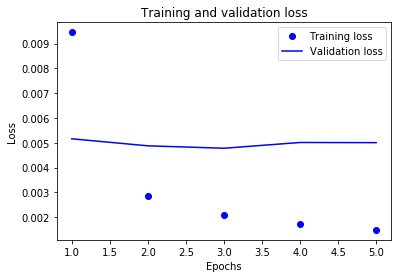

In [149]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, 6)

plt.plot(epochs, loss_values, 'bo', label='Training loss')           
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')      
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

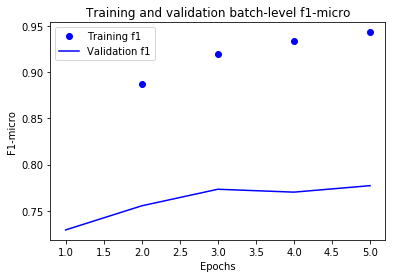

In [150]:
plt.clf()    

f1_values = history_dict['f1']
val_f1_values = history_dict['val_f1']

plt.plot(epochs, f1_values, 'bo', label='Training f1')
plt.plot(epochs, val_f1_values, 'b', label='Validation f1')
plt.title('Training and validation batch-level f1-micro')
plt.xlabel('Epochs')
plt.ylabel('F1-micro')
plt.legend()

plt.show()

### Save results arrays

In [151]:
def to_file(array,name):
    df = pd.DataFrame(data = array.tolist(),columns=[i for i in range(1,211)])
    df.to_csv(os.path.join(DATADIR, name+'_results.csv.gz'),compression='gzip',index=False)

In [152]:
date_run = time.strftime("_%H%M_%d%m_")
date_run

'_2150_1902_'

In [154]:
y_prob = parallel_model.predict([meta_train, title_train, desc_train, x_train])
to_file(y_prob,"train"+date_run)

In [155]:
y_pred = y_prob.copy()
y_pred[y_pred>=P_THRESHOLD] = 1
y_pred[y_pred<P_THRESHOLD] = 0

In [156]:
print('micro: {}'.format(precision_recall_fscore_support(y_train, y_pred, average='micro', sample_weight=None)))
print('macro: {}'.format(precision_recall_fscore_support(y_train, y_pred, average='macro', sample_weight=None)))
print('weightedmacro: {}'.format(precision_recall_fscore_support(y_train, y_pred, average='weighted', sample_weight=None)))

micro: (0.9678354854557587, 0.96206143787514897, 0.96493982399546752, None)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


macro: (0.97521822663811653, 0.97627836556599012, 0.97558281374989142, None)
weightedmacro: (0.9678693117607724, 0.96206143787514897, 0.96472319723727806, None)


In [157]:
y_prob_dev = parallel_model.predict([meta_dev, title_dev, desc_dev, x_dev])

In [158]:
to_file(y_prob_dev,"dev"+date_run)

In [159]:
y_pred_dev = y_prob_dev.copy()
y_pred_dev[y_pred_dev>=P_THRESHOLD] = 1
y_pred_dev[y_pred_dev<P_THRESHOLD] = 0

In [160]:
print('micro: {}'.format(precision_recall_fscore_support(y_dev, y_pred_dev, average='micro', sample_weight=None)))
print('macro: {}'.format(precision_recall_fscore_support(y_dev, y_pred_dev, average='macro', sample_weight=None)))
print('weightedmacro: {}'.format(precision_recall_fscore_support(y_dev, y_pred_dev, average='weighted', sample_weight=None)))

micro: (0.79570318693515141, 0.7595157018539539, 0.77718843160788253, None)
macro: (0.5867462563309056, 0.54606944472253616, 0.54559264526683793, None)
weightedmacro: (0.79696781018403062, 0.7595157018539539, 0.77388366961112087, None)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [161]:
print('weightedmacro: {}'.format(precision_recall_fscore_support(y_dev, y_pred_dev, average=None, sample_weight=None)))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


weightedmacro: (array([ 0.5       ,  1.        ,  1.        ,  1.        ,  0.        ,
        0.64285714,  0.5       ,  0.80701754,  0.        ,  1.        ,
        0.        ,  0.7826087 ,  1.        ,  0.        ,  0.56363636,
        1.        ,  0.57142857,  0.        ,  0.        ,  0.75384615,
        0.82259768,  0.6746988 ,  0.8045977 ,  0.        ,  0.6       ,
        0.5       ,  1.        ,  0.75      ,  0.92857143,  1.        ,
        0.71428571,  1.        ,  0.        ,  0.6969697 ,  0.84397163,
        0.48387097,  0.70422535,  0.5       ,  0.63636364,  0.69491525,
        0.        ,  0.6969697 ,  0.5       ,  0.        ,  0.37037037,
        0.4       ,  0.        ,  0.95652174,  0.70224719,  0.        ,
        1.        ,  0.33333333,  0.        ,  0.        ,  0.66666667,
        0.66666667,  0.        ,  0.88679245,  0.2       ,  0.78846154,
        0.61111111,  1.        ,  0.77777778,  0.73913043,  0.        ,
        0.69620253,  0.        ,  0.85714286,  1

In [162]:
to_file(y_train,"true_train"+date_run)

In [163]:
to_file(y_dev,"true_dev"+date_run)